# А/В тестирование и анализ гипотез увеличения выручки интернет-магазина

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth',150)

In [3]:
hypothesis = pd.read_csv('/Users/ruslangayfullin/DA_New/YP/project_7_ab_test/hypothesis.csv')

In [4]:
orders = pd.read_csv('/Users/ruslangayfullin/DA_New/YP/project_7_ab_test/orders.csv')
visitors = pd.read_csv('/Users/ruslangayfullin/DA_New/YP/project_7_ab_test/visitors.csv')

### Предобработка 

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders.duplicated().sum()

0

In [8]:
# проверим сколько пользователей в каждой из групп
orders.groupby('group',as_index=False)['visitorId'].nunique()

,group,visitorId
0,A,503
1,B,586


In [9]:
# проверим количество пользователей которые одновременно находятся в группе А и группе В
print('Количество пересекающихся пользователей: {}'.format(len(orders.groupby('visitorId',as_index=False)['group'].nunique().query('group >1'))))

Количество пересекающихся пользователей: 58


In [10]:
#удалим из датасета пересекающихся пользователей 
list_of_crossing_id =  list(orders
                            .groupby('visitorId',as_index=False)['group']
                            .nunique()
                            .query('group >1')['visitorId'])

orders = orders.query('visitorId not in @list_of_crossing_id').reset_index(drop=True)


In [11]:
orders['date'] = pd.to_datetime(orders['date'])

In [12]:
print('Период проведения теста для группы А c {} по {}'.format(orders.query('group == "A"')['date'].dt.date.min(),orders.query('group == "A"')['date'].dt.date.max()))
print('Период проведения теста для группы В c {} по {}'.format(orders.query('group == "B"')['date'].dt.date.min(),orders.query('group == "B"')['date'].dt.date.max()))



Период проведения теста для группы А c 2019-08-01 по 2019-08-31
Период проведения теста для группы В c 2019-08-01 по 2019-08-31


Период проведения теста для каждой группы совпадает. В датасете присутствует 58 пользователей, которые пересекаются и участвуют сразу в двух контрольных группах. При этом сами группы не одинаковы по количеству участников, что искажает результаты теста. Составителям теста необходимо доработать методику формирования групп в будущем

In [13]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [14]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [15]:
visitors.duplicated().sum()

0

In [16]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [17]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [18]:
hypothesis.columns = hypothesis.columns.str.lower()

## Приоритезация гипотез

Применим фреймворк ICE для приоритизации гипотез


In [19]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False)



,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Применим фреймворк RICE для приоритизации гипотез. 

In [20]:

hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Результат приоретизации гипотез с применением фреймворка ICE отличается от результатов с применением метода RICE, так как метод RICE учитывает охват пользователей, которых затронет изменение.
Так, гипотеза "Запустить акцию, дающую скидку на товар в день рождения" по методу ICE является наиболее приоритетным, при этом учитывая низкий охват, который имеет данное изменение, по методу RICE гипотеза перемещается с 1 на 5 место.

Наибольший охват и эффективность одновременно, имеет гипотеза 7 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". По методу RICE она в 2 раза превосходит следующую за ней гипотезу

## А/В тест

Построение графика кумулятивной выручки по группам.

In [21]:
datesGroups = orders[['date','group']].drop_duplicates()

In [22]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'transactionId' : 'nunique', 
          'visitorId' : 'nunique', 
          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                      visitors['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

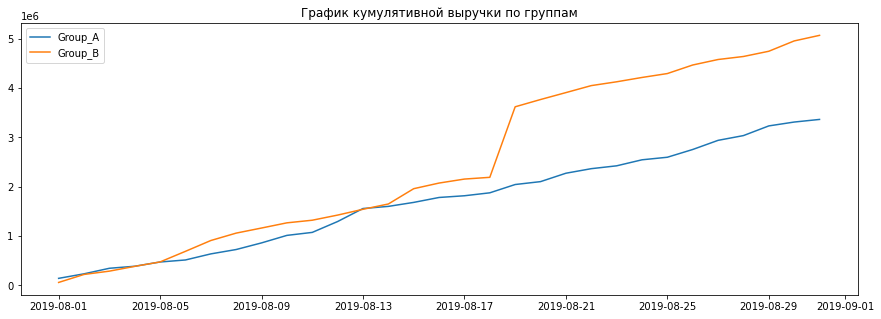

In [23]:

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Group_A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Group_B')
plt.title('График кумулятивной выручки по группам')
plt.legend();

Графики выручки обеих групп показывают стабильный рост. При этом в группе В после 17 августа наблюдается один случай резкого роста выручки. Это может быть вызвано как резким ростом числа заказов, так и наличием очень дорогих заказов в группе В.

Построение графика кумулятивного среднего чека по группам


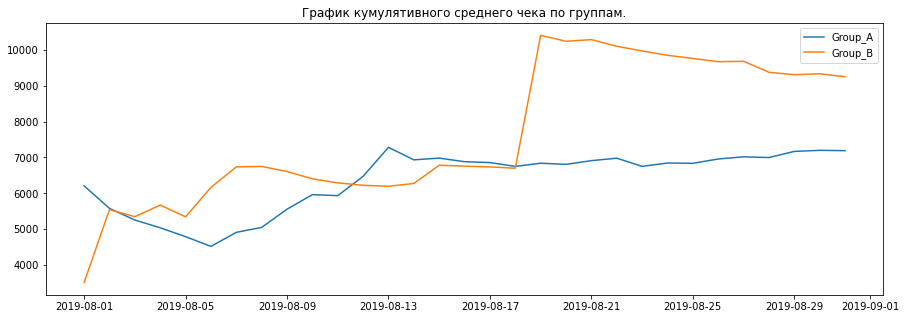

In [24]:
plt.figure(figsize=(15,5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Group_A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Group_B')
plt.title('График кумулятивного среднего чека по группам.')
plt.legend();

График кумуятивного среднего чека показывает скачкообразный рост чека в группе В после 17 августа. После чего сердний чек несущесвтенно снижается, однако так и не достигает уровня группы А. Вероятно это связано с приходом клиентов, которые совершают дорогие покупки

Построение графика относительного изменения кумулятивного среднего чека группы B к группе A. 


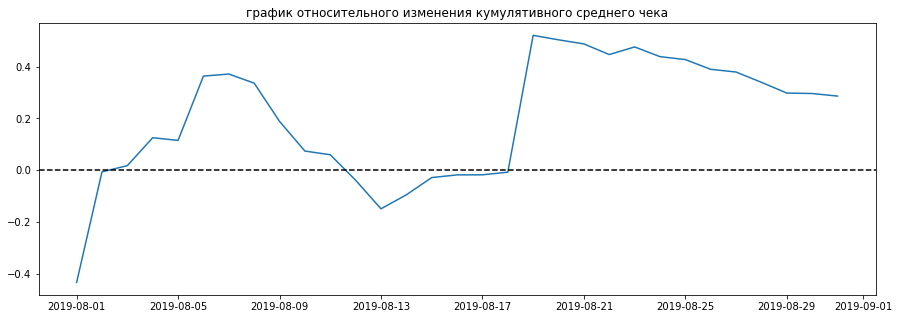

In [25]:
plt.figure(figsize=(15,5))

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('график относительного изменения кумулятивного среднего чека')
plt.axhline(y=0, color='black', linestyle='--');

График изменения среднего чека группы В относительно А показывает несколько резких скачков. При этом резкий рост графика совпадает с ростом кумулятивного среднего чека группы В - и связан с наличием дорогих заказов, изменяющих средние значения

Построение графика кумулятивной конверсии по группам.


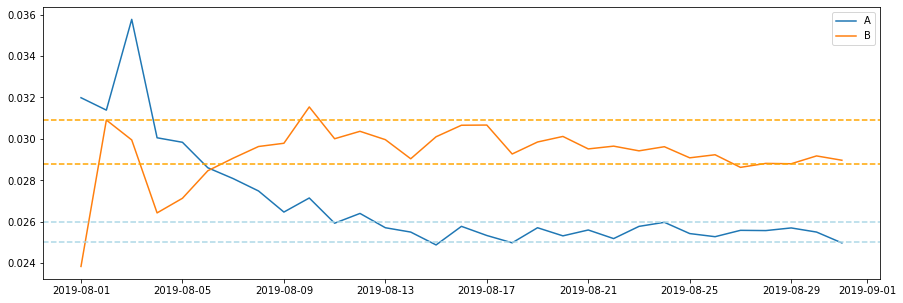

In [26]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']


cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend();

plt.axhline(y=0.0288, color='orange', linestyle='--')
plt.axhline(y=0.0309, color='orange', linestyle='--')

plt.axhline(y=0.025, color='lightblue', linestyle='--')
plt.axhline(y=0.026, color='lightblue', linestyle='--');


Графики конверсии показывали резкие скачки в начале наблюдений, однако потом стабилизировались - конверсия группы А около значений 0.025, конверсия группы В - между 0.029 и 0.031. График показывает что конверсия в группе В стабильно выше

Построение графика относительного изменения кумулятивной конверсии группы B к группе A.


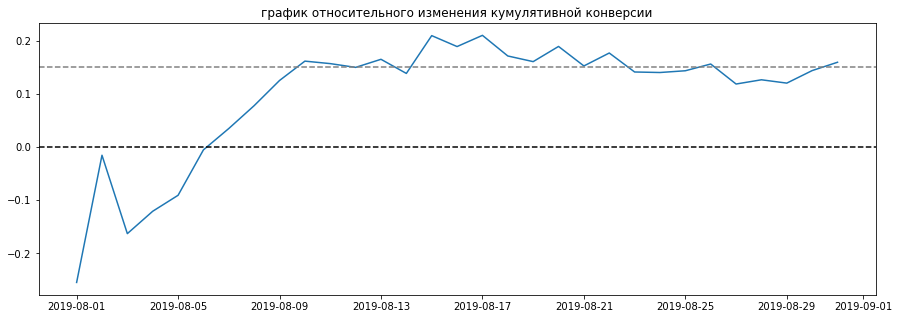

In [27]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('график относительного изменения кумулятивной конверсии')


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--');


График относительного изменения кумулятивной конверсии подтверждает показания предыдущего графика - конверсия В существенно после стабилизации первых дней наблюдения - превышает конверсию группы А

Построение точечного графика количества заказов по пользователям. 


In [28]:
orders_by_users = orders.groupby('visitorId',as_index=False).agg({'transactionId':'nunique'})
orders_by_users.columns = ['userId', 'orders']

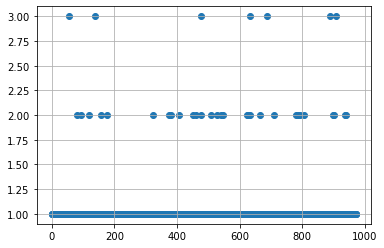

In [29]:
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.grid();

график количества заказов по пользователям показывает, что большинство пользователей совершает 1 или 2 покупки. При этом достаточно часто встречаются пользователи которые соврешили 3 покупки. Те, кто совершил более трех покупок встречаются довольно редко. При этом в данных есть отдельные пользователи, которые совершили более 10 покупок, но их число несущественно

Определение 95-й и 99-й перцентили количества заказов на пользователя.

In [30]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли более 2 заказов и только 1% оформили более 4 заказов. Следовательно, для анализа целесообразно отобрать подавляющее большинство пользователей, тех 95% , которые оформили не более 2 заказов

Построение точечного графика стоимостей заказов.


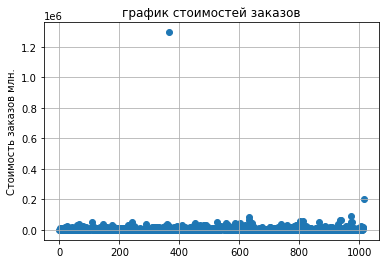

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.grid()

plt.ylabel('Стоимость заказов млн.')
plt.title('график стоимостей заказов');

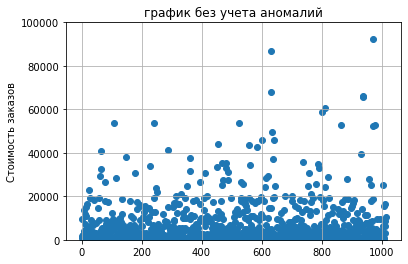

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0,100000)
plt.grid()
plt.ylabel('Стоимость заказов')
plt.title('график без учета аномалий');

Подавляющее большинство заказов стоит до 20000. При этом есть отдельные выбросы на уровне 200 тыс. и свыше 1,2 млн

9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.


In [33]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% пользователей совершали заказы свыше 28 тыс, и только 1% - свыше 58.2 тыс. Следовательно для дальнейшего анализа можно учитывать 95% пользователей, которые совершили заказов на стоимость до 28 тыс.

**Рассчет статистической значимости различий в конверсии между группами по «сырым» данным.**


**Проверяем гипотезу**
* H0:Cтатистическаая значимость различий в конверсии между группами отсутствует 
* H1: имеется статистическая значимость между конверсией  двух групп

        
    Для проверки гипотезы применим непараметрический метод Манна-Уитни, который применяется при наличии выбросов, сильно сдвигающих параметрические результаты.


In [34]:
# сформируем датасет, в котором соберем данные по дням и кумулятивные данные для каждой из тестовых групп

# определение пользователей за день по группам
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

# определение накопления пользователей по группам
visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitors_per_date_a': 'sum'}),axis=1)

visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitors_per_date_b': 'sum'}),axis=1)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

# количество заказов по дням по группам
orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))
orders_daily_a.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']
orders_daily_a

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))
orders_daily_b.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

#кумулятивное количество заказов
orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}),axis=1).sort_values(by=['date'])
orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}),axis=1).sort_values(by=['date'])
orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']

# объединим в общий датасет данные по дням и кумулятивные данные
merged_data = (
    orders_daily_a.merge(orders_daily_b, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a,left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b,left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a,left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b,left_on='date', right_on='date', how='left')    
)
merged_data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [35]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 


In [36]:
sample_a = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, 
                               index=np.arange(merged_data['visitors_per_date_a'].sum() - len(ordersByUsersA['orders']))
                               , name='orders')],axis=0)


sample_b = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, 
                               index=np.arange(merged_data['visitors_per_date_b'].sum() - len(ordersByUsersB['orders'])), 
                               name='orders')],axis=0) 

In [37]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Различие в средних: {0:.3f}'.format(sample_b.mean()/sample_a.mean()-1)) 

p-value: 0.011
Различие в средних: 0.160



По итогам теста Манна-Уитни на "сырых" данных до обработки выбросов можно отвергнуть гипотезу об отустствии статистически значимых различий между двумя группами А и В, так как p-value = 0.011, что является меньшим значением чем предел стат значимости 0.05.
Различие в средних значениях составляет 0.160

**Рассчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным**

Проверяем гипотезу
* H0:Cтатистическаая значимость различий вв среднем чеке заказа между группами отсутствует 
* H1: имеется статистическая значимость между в среднем чеке заказа между группами

    
    
    Для проверки гипотезы применим непараметрический метод Манна-Уитни, который применяется при наличии выбросов, сильно сдвигающих параметрические результаты. 


In [38]:
print('p-value: {0:.3f}'
      .format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('различие в среднем чеке {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
различие в среднем чеке 0.287


P-value составил 0.829, что превышает альфа значение 0.05. Нулевую гипотезу Н0, о том, что средние чеки двух групп пользователей равны, отвегнуть не получилось

При этом показатель различия среднего чека показывает превышение среднего чека группы В над чеком группы А 

**Рассчет статистической значимости различий в конверсии между группами по «очищенным» данным**


In [39]:
users_with_many_orders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitorId']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)


In [40]:
len(abnormal_users)

55

In [41]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormal_users))]['orders'],
        pd.Series(
            0,
            index=np.arange(
                merged_data['visitors_per_date_a'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormal_users))]['orders'],
        pd.Series(
            0,
            index=np.arange(
                merged_data['visitors_per_date_b'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0,)

In [42]:
print('p_value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Различие в средних: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p_value: 0.009
Различие в средних: 0.189


После обработки сырых данных существенных различий не наблюдается.  p-value изменилась с 0.011 до 0.009, все еще оставаясь ниже 0.05

Различие в средних значениях выросло с 0.160 до 0.189

По итогам теста Манна-Уитни можно отвергнуть гипотезу об отустствии статистически значимых различий между двумя группами А и В в конверсии заказов

**По очищенным данным конверсия также различна. Выбросы не повлияли на результаты**

**Рассчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным**

In [43]:
print(
    'p_value: {0:.3f}'.format(stats.mannwhitneyu(
        orders[np.logical_and(orders['group'] == 'A',
                              np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
            orders[np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])[1]))

print(
    "различие в среднем чеке {0:.3f}".format(orders[np.logical_and(orders['group'] == 'B',
                                           np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                                np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean() - 1))


p_value: 0.762
различие в среднем чеке -0.022


После обработки данных гипотезу о том что средние чеки двух групп пользователей равны, все еще отвегнуть нельзя. P-value изменился с 0.829 до 0.762. Средние чеки существенно отличаются. 

При этом показатель различия среднего чека между группами А и В изменился с 0.287 на -0.022. Следовательно средний чек группы В в среднем ниже группы А

# Общий вывод

- Графики выручки обеих групп показывают стабильный рост. При этом в группе В после 17 августа рост выручки существенно выше чем в группе А
- График кумуятивного среднего чека показывает рост чека в группе В после 17 августа.  При этом нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
- График конверсии показывает что конверсия в группе В стабильно выше. Гипотеза от отсутствии статистически значимых различий между двумя группами А и В в конверсии заказов не была отвергнута, что подтверждает значения графиков


Общими итогами теста можно считать следующие:
Увеличение выручки интернет магазина действительно произошло для группы В, при этом увеличение сопровождалось ростом конверсии а не ростом среднего чека. 

<b>Следовательно, тест может считаться успешным, и может  быть завершен. Победу можно присвоить группе B
